In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Creating class for the traffic simulation
class TrafficSimulation():
    def __init__(self, road_length, traffic_density, max_velocity, prob_slow, num_of_lanes=3, prob_lane_change=0.9, look_back = 3, verbose=True):
        self.road_length = road_length #Length of each lane on the road
        self.traffic_density = traffic_density #Density of each lane on the road
        self.max_velocity = max_velocity #Max velocity a car can travel
        self.prob_slow = prob_slow #probability of randomly slowing down
        self.prob_lane_change = prob_lane_change #probability of changing lanes given other conditions are met
        self.num_of_lanes = num_of_lanes #number of lanes on the road
        self.look_back = look_back #number of cell to look back when changing lanes
        self.lane_changes = 0 #number of lanes changes total made by cars
        self.total_flow = 0 #flow of traffic through a certain point
        self.verbose = verbose #Boolean to print detailed output
        
        #Initializing the road with randomly chosen cars and velocities
        number_of_cars = int(traffic_density * road_length)
        self.road = np.zeros(shape=(num_of_lanes, road_length), dtype=int)
        for l in range(num_of_lanes):
            lane = np.append(np.random.choice(6,number_of_cars), [-1] * (road_length - number_of_cars))
            np.random.shuffle(lane)
            self.road[l] = lane
        
    def get_cars(self):
        #returns a list of all the cars in the lane with their position and velocity
        lane_cars = []
        for l, lane in enumerate(self.road):
            car_list = []
            for ind, car in enumerate(lane):
                if car != -1:
                    car_list = car_list + [[ind, car]]
            lane_cars.append(car_list)
        return (lane_cars)
    
    def update_road(self):
        #main function to update each timestep
        all_cars = self.get_cars()
        for ind, lane in enumerate(all_cars):
            if self.num_of_lanes > 1:
                #check for lane switches in multi-lane model
                self.change_lane(ind, lane)
            #update horizontal movement forward
            self.update_lane(ind, lane)
        
    def update_lane(self, lane_ind, cars_in_lane):
        #Move cars forward for each lane
        next_state = cars_in_lane
        for ind, car in enumerate(next_state):
            if next_state[ind] == next_state[-1]:
                #Find distance to the next car
                next_distance = (self.road_length - car[1] - 1) + next_state[0][1] #((next_state[0][0] + car[0])%self.road_length) + 1
            else:
                next_distance = next_state[ind+1][0] - car[0]
            if car[1] < self.max_velocity and next_distance > car[1] + 1:
                #Acceleration of car
                car[1] = car[1] + 1
            if next_distance <= car[1]:
                #Slow
                car[1] = next_distance - 1
            if np.random.uniform() < self.prob_slow and car[1] > 0:
                #Random Slowdown
                car[1] = car[1] - 1
        self.move_cars(lane_ind, next_state)
    
    def move_cars(self,lane_ind, state):
        #calculate the flow of traffic
        self.calc_flow(lane_ind)
        updated_state = [-1] * self.road_length
        for position, velocity in state:
            #Checking for periodic boundary conditions
            position = (position + velocity)%self.road_length
            updated_state.insert(position,velocity)
        self.road[lane_ind] = updated_state[:self.road_length]
    
    def change_lane(self,lane_ind, state):
        #Checking for conditions of lane change
        self.lane_changes = 0
        lane_up = lane_ind - 1 if lane_ind > 0 else -1 #index of lane above
        lane_down = lane_ind + 1 if lane_ind < self.num_of_lanes - 1 else -1 #index of lane below
        for ind in range(len(state)):
            ind = -1 if ind == len(state) - 1 else ind
            if state[ind][0] + state[ind][1] + 1 >= state[ind+1][0]: #if progress forward cannot be made
                #look forward and backward in lane above
                if lane_up != -1:
                    forward_up_dist = self.look_forward(lane_up, state[ind][0], state[ind][1])
                    back_up_gap = self.look_backward(lane_up, state[ind][0], state[ind][1])
                elif lane_up == -1:
                    forward_up_dist = -1
                #look forward and backward in lane below
                if lane_down != -1:
                    forward_down_dist = self.look_forward(lane_down, state[ind][0], state[ind][1])
                    back_down_gap = self.look_backward(lane_down, state[ind][0], state[ind][1])
                elif lane_down == -1:
                    forward_down_dist = -1
                #probability of switching
                switch = True if np.random.uniform() < self.prob_lane_change else False
                diff = forward_up_dist - forward_down_dist
                #Taking difference to pick best of the two lanes to switch into
                if switch and diff > 0 and back_up_gap > self.look_back:
                    self.lane_changes += 1
                    self.road[lane_up][state[ind][0]] = state[ind][1]
                    self.road[lane_ind][state[ind][0]] = -1
                    #switch to upper lane
                elif switch and diff < 0 and back_down_gap > self.look_back:
                    self.lane_changes += 1
                    self.road[lane_down][state[ind][0]] = state[ind][1]
                    self.road[lane_ind][state[ind][0]] = -1
                    #switch to lower lane
                else:
                    pass
                    #don't switch
        if self.num_of_lanes > 1 and self.verbose:
            print ("number of cars changing lane in lane %s is %s"%(lane_ind, self.lane_changes))
                    
                         
    def look_forward(self, lane_ind, position, velocity):
        #function to look forward in other lanes
        dist = -1
        for i in range(self.max_velocity + 1):
            if self.road[lane_ind][(position+i)%self.road_length] == -1:
                dist += 1
            else:
                break
        return dist
        
    def look_backward(self, lane_ind, position, velocity):
        #function to look behind in other lanes
        dist = -1
        for i in range(self.max_velocity,0,-1):
            if self.road[lane_ind][abs(position-i)] == -1:
                dist += 1
            else:
                break
        return dist
    
    def calc_flow(self,lane_ind):
        #function to calculate flow of cars through a point
        for i in range(self.road_length-1, self.road_length-self.max_velocity-2, -1):
            next_step = i + self.road[lane_ind][i] if self.road[lane_ind][i] != -1 else -1
            if next_step >= self.road_length:
                self.total_flow += 1
                
    def display(self):
        #function to show the state of the road
        for lane in self.road:
            print (''.join('.' if x == -1 else str(x) for x in lane))
        if self.num_of_lanes>1:
            print ("\n")
    
    

In [3]:
#Simulation with one lane

one_lane_sim = TrafficSimulation(100,0.4,5,0.3,1)

for time_step in range(30):
    one_lane_sim.update_road()
    one_lane_sim.display()

05...3.....2......5.......3.100.1..2.000.1.1.100.....5.00.0.00.1....0..2.10.....50..20.1..100..20...
0...3...3.....3........5...100.1.1.0.00.10.0.00.1.....100..100...2...1..10.1....00..00...2000..0.1..
.1.....3...3......4......2.000..10..100.00.0.0.1..2...00.1.000......3..20.1..2..0.1.0.1..000.1.0...2
..31.......3....4......4..0.000..0.1.00.10.1.10..1....300.0.000.......1.0.1.1...2.1.1.1..2000..10...
..0.1..........4.....5...2.100.1.0.0.0.100.0.00....2..000..100.1......0..10...2..1.1.1..2000.1.00...
...1.1.............4...2..1000..1.1.10.00.1.10.1....1.000..000..1......1.00.....2.10...2000.1.10.1..
....1..2..............3..2000.1.0.0.0.10.1.10.1..2...1000..00.1..1......10.1.....100...0000..100...2
..3...1....3............1.000.1.1.10.0.0.10.0.1..2...3000.1.00...2..2....0.1.1....00.1..000.1.00.1..
....2...2.....3..........1000.0.0.0.1.1.10.10..1....3000.1.10.1....2..2...1.1..2..0.1..200.1.10.1..2
..3.....3...3......4......000.1.1.1.1.1.10.100...1...000.1.10.1.1....1...2..1..2..20..1.00.

In [4]:
#Simulation with two lanes

two_lane_sim = TrafficSimulation(100,0.3,5,0.3,2)

for time_step in range(30):
    two_lane_sim.update_road()
    two_lane_sim.display()

number of cars changing lane in lane 0 is 1
number of cars changing lane in lane 1 is 0
.1....3.1.....20...2......3.......3.1.1.100...30.1.1..1.0..20.1......0.....1..2....00...2...00......
.4.200.1000000.10....4.1....1.........2...2..2......4..0.....10.00.....4...1.........1...3.......0..


number of cars changing lane in lane 0 is 1
number of cars changing lane in lane 1 is 0
...2..0...2...0.1.....3.......4....10..100.1..0.1.1.1.0..1.00..1.....0......1....3.0.1....2.0.1.....
..100.1000000.10.1....1.1.....2..........3..2...3....1..1....0.10.1.......3..2.........2.....4....1.


number of cars changing lane in lane 0 is 1
number of cars changing lane in lane 1 is 1
..1..2.1.....3.1..2......3........40.1.00.1..20..1.1.1.1..10.1...2....1.......2...10...2...10...2...
..000.000000.100...2...1..2......3.........2...3....4..2.1...0.0.1.1........2...3........2.......4.1


number of cars changing lane in lane 0 is 2
number of cars changing lane in lane 1 is 0
...1.0..1....0...2..2........4....00

In [5]:
##Simulation with three lanes

three_lane_sim = TrafficSimulation(100,0.3,5,0.3,3)

for time_step in range(30):
    three_lane_sim.update_road()
    three_lane_sim.display()

number of cars changing lane in lane 0 is 0
number of cars changing lane in lane 1 is 2
number of cars changing lane in lane 2 is 1
........2....1...3....1....4......00.....1...30.1.00.10.10.1.10.000.....4........30.....3..400...2.1
3..........2....4..0.1......5.2.....10...3...3.1...30.10.1..2..2...0..20.1...3.1...3....4...30..20..
.51.....5....4...0..10.....4....3.....5...1....4....3..0.1..100....4...30...3.1..2..2000..1..2......


number of cars changing lane in lane 0 is 0
number of cars changing lane in lane 1 is 0
number of cars changing lane in lane 2 is 1
1...........3..1......4..2......4..0.1......2.00.0.00.00.0.1.100.00.1.........5...00......1.00.1..0.
....4........43...2.1..2.....1..2...0.1.....30...2.00.0.1..2..2...30..00...2..1..2.....4...300..00..
.0.1.......3....30..0.1........4....4....3.1.......4.1..1..200.1......30.1..0..1...20000...1....3...


number of cars changing lane in lane 0 is 1
number of cars changing lane in lane 1 is 1
number of cars changing lane in lane 2

In [6]:
#Taking multiple densities to run trials
densities = np.linspace(0.02,0.9,30)

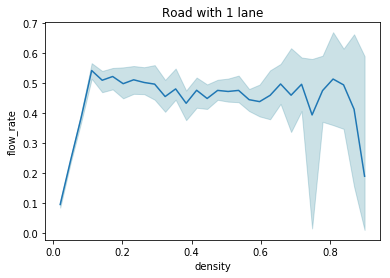

In [7]:
avg_flow = []
conf_int = []

for d in densities:
    per_trial = []
    for trial in range(10):
        flow_rate = 0
        sim = TrafficSimulation(100,d,5,0.3,1,verbose=False)
        for _ in range(200):
            sim.update_road()
        flow_rate = sim.total_flow/200
        per_trial.append(flow_rate)
    #Calculating average flow rate of the cars
    avg_flow.append((d,np.average(per_trial)))
    #Calculating confidence intervals
    conf_int.append(np.percentile(per_trial, [10, 90]))

x,y = zip(*avg_flow)
y_up, y_down = zip(*conf_int)
plt.clf()
plt.fill_between(x, y_down, y_up, color="#539caf", alpha =0.3)
plt.plot(x,y)
plt.xlabel("density")
plt.ylabel("flow_rate")
plt.title("Road with 1 lane")
plt.show()

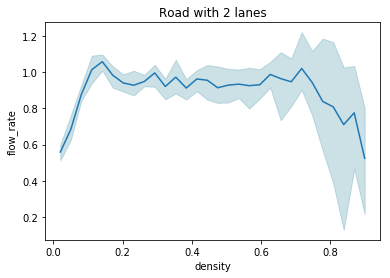

In [8]:
avg_flow = []
conf_int = []

for d in densities:
    per_trial = []
    for trial in range(10):
        flow_rate = 0
        sim = TrafficSimulation(100,d,5,0.3,2,verbose=False)
        for _ in range(200):
            sim.update_road()
        flow_rate = sim.total_flow/200
        per_trial.append(flow_rate)
    #Calculating average flow rate of the cars
    avg_flow.append((d,np.average(per_trial)))
    #Calculating confidence intervals
    conf_int.append(np.percentile(per_trial, [10, 90]))

x,y = zip(*avg_flow)
y_up, y_down = zip(*conf_int)
plt.clf()
plt.fill_between(x, y_down, y_up, color="#539caf", alpha =0.3)
plt.plot(x,y)
plt.xlabel("density")
plt.ylabel("flow_rate")
plt.title("Road with 2 lanes")
plt.show()

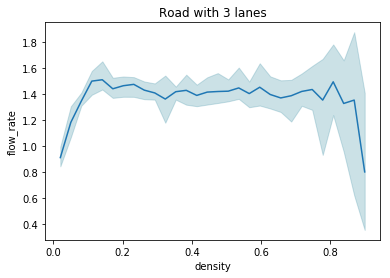

In [9]:
avg_flow = []
conf_int = []

for d in densities:
    per_trial = []
    for trial in range(10):
        flow_rate = 0
        sim = TrafficSimulation(100,d,5,0.3,3,verbose=False)
        for _ in range(200):
            sim.update_road()
        flow_rate = sim.total_flow/200
        per_trial.append(flow_rate)
    #Calculating average flow rate of the cars
    avg_flow.append((d,np.average(per_trial)))
    #Calculating confidence intervals
    conf_int.append(np.percentile(per_trial, [10, 90]))

x,y = zip(*avg_flow)
y_up, y_down = zip(*conf_int)
plt.clf()
plt.fill_between(x, y_down, y_up, color="#539caf", alpha =0.3)
plt.plot(x,y)
plt.xlabel("density")
plt.ylabel("flow_rate")
plt.title("Road with 3 lanes")
plt.show()